# Novel Chest X-Ray Classifier

In this notebook, Clara’s transfer learning capabilities are used to train a novel chest x-ray classifier for COVID.

Transfer learning consists of using the visual features and weigths from a pre-trained relevant classifier as a starting point for training of the new classifier 

In [16]:
from IPython.display import Image
from TransformInputData import transform,transformMetadataToJSON,adaptFineTuningConfig,adaptJSONTrainConfigFile,adaptJSONValidationConfigFile,adaptJSONFile

The TranformInputData library contains a series of simple functions that transform the input data into the format expected by the Clara's SDK, it also has functions that adapt the config files from the base classifier to the desired specs for the new classifier (Labels, learning_rate, num epochs, etc.)  

## Let’s Get a Dataset

Of course, the first step to training a model is to have data. If you have access to a medical imaging data source, that’s great! For this exercise, though, I will use a public dataset that is in a mishmash of imaging formats already. 

We will use a dataset that states it is publicly available on Github.

In [1]:
if not path.exists('covid-chestxray-dataset'):
    !git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1741 (delta 69), reused 84 (delta 55), pack-reused 1616
Receiving objects: 100% (1741/1741), 221.08 MiB | 65.58 MiB/s, done.
Resolving deltas: 100% (843/843), done.
Checking out files: 100% (357/357), done.


#### Let's take a look at one of the images

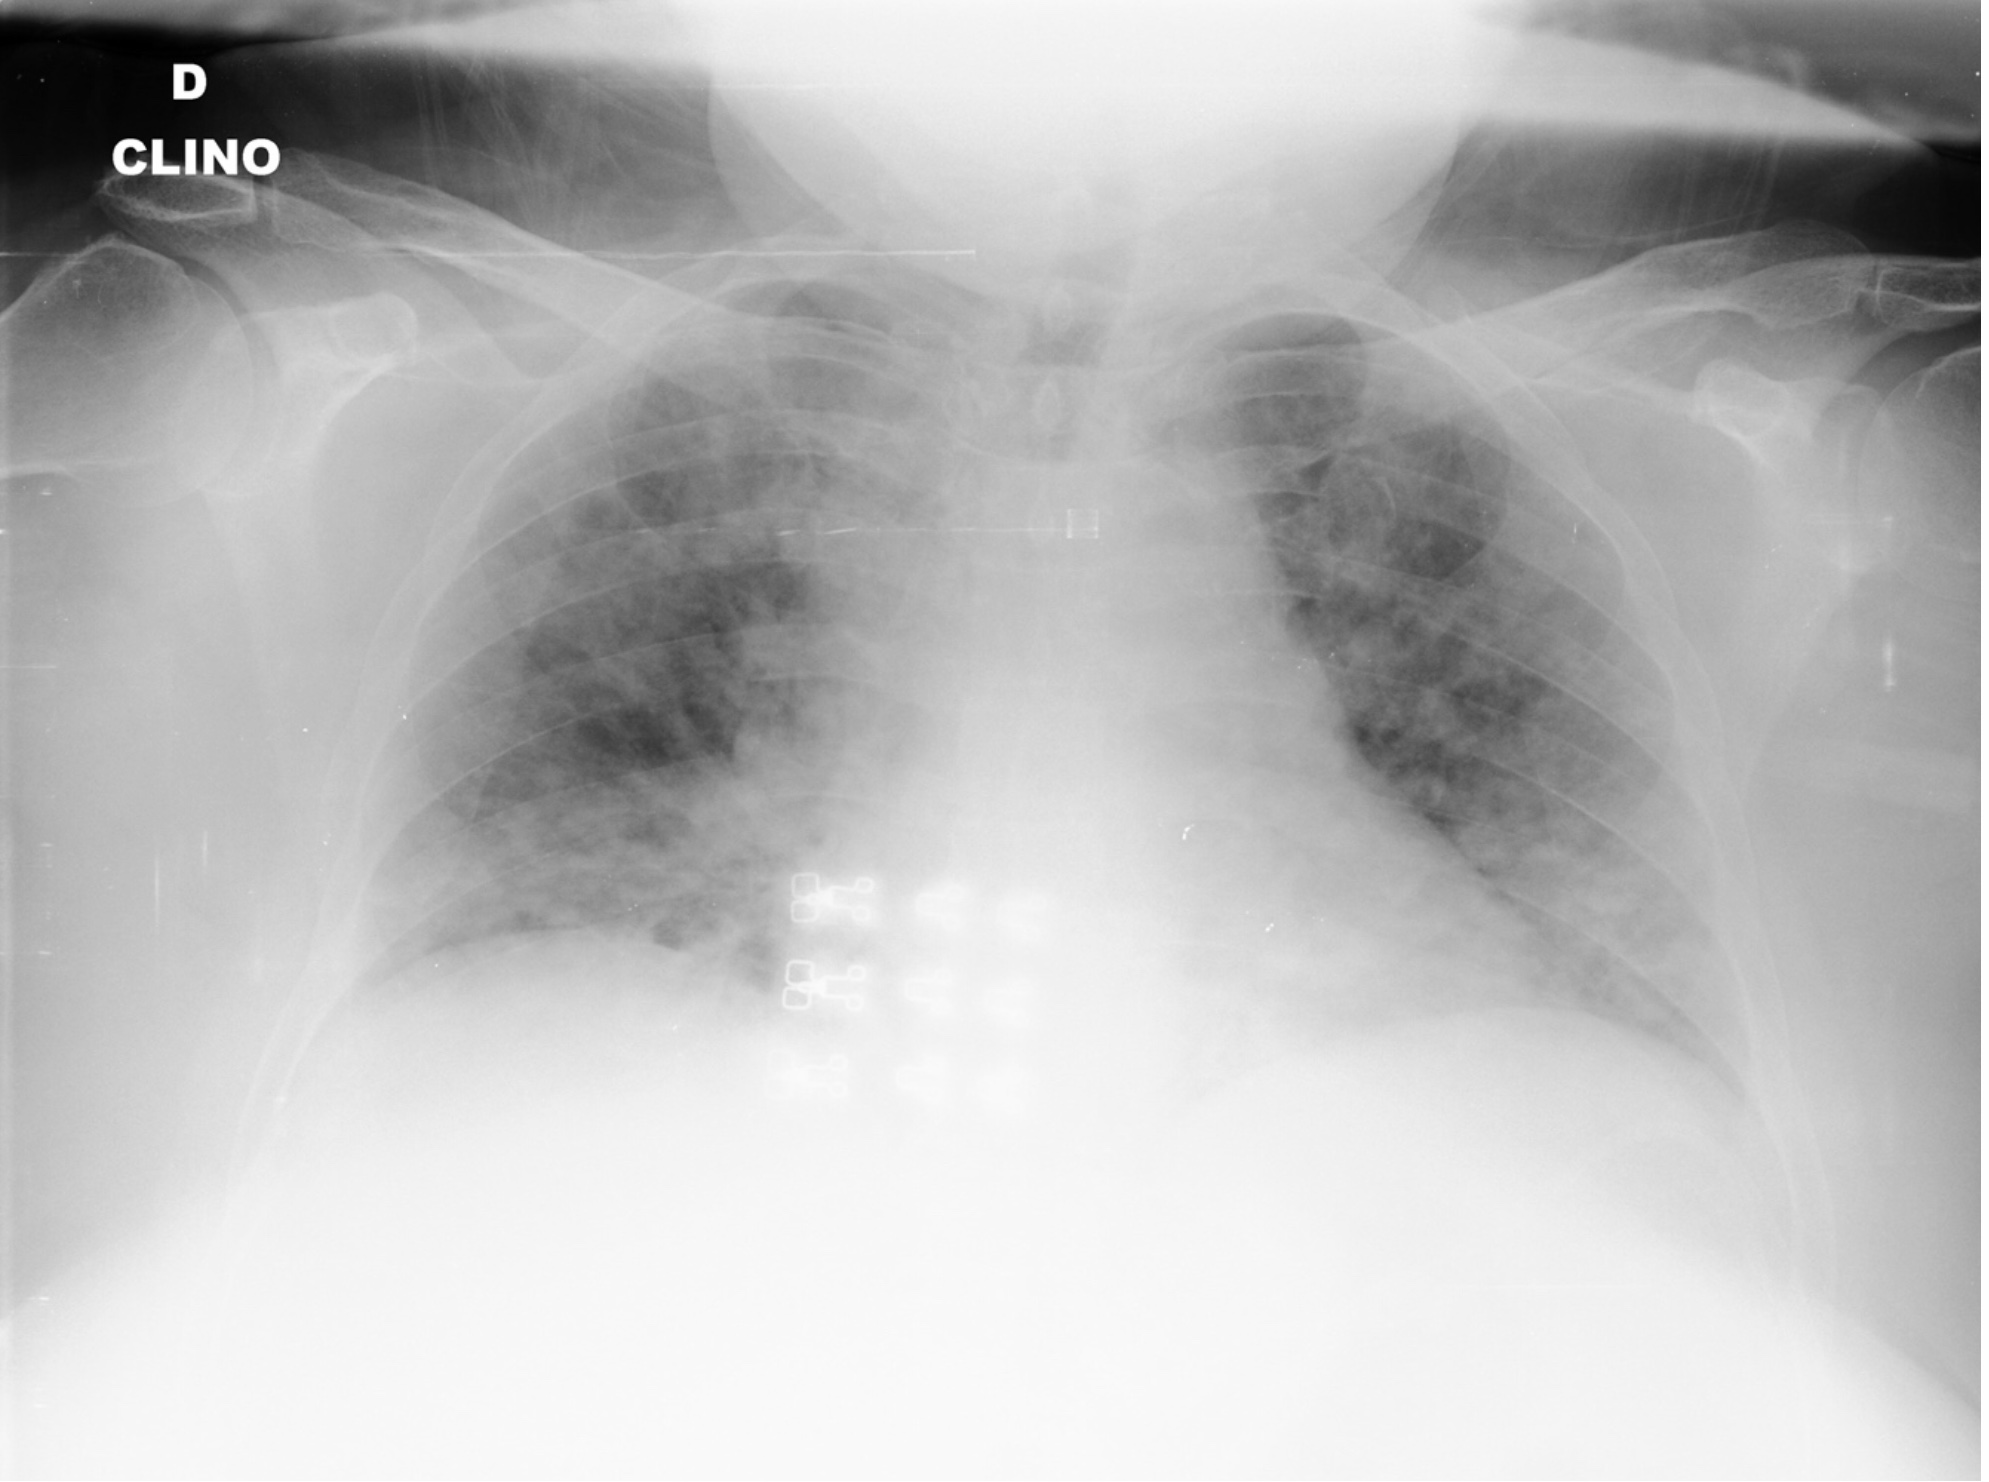

In [3]:
dataDir = 'covid-chestxray-dataset/images/'
d = !ls $dataDir
Image(filename= dataDir + d[0]) 

The images come in a myriad of formats, so we need to first get them into a uniform format.
Here we make sure we have the appropiate image processing libraries

In [1]:
!apt-get install python3-distutils
!apt update
!apt install python3-pip -y
!apt install libjpeg8-dev zlib1g-dev libtiff-dev libfreetype6 libfreetype6-dev libwebp-dev libopenjp2-7-dev libopenjp2-7-dev -y
!pip3 install pillow --global-option="build_ext" --global-option="--enable-zlib" --global-option=”--enable-jpeg” --global-option="--enable-tiff" --global-option="--enable-freetype" --global-option="--enable-webp" --global-option="--enable-webpmux" --global-option="--enable-jpeg2000"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be upgraded:
  python3-distutils
1 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.
Need to get 144 kB of archives.
After this operation, 685 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-distutils all 3.6.9-1~18.04 [144 kB]
Fetched 144 kB in 0s (346 kB/s)          
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
(Reading database ... 35494 files and directories currently installed.)
Preparing to unpack .../python3-distutils_3.6.9-1~18.04_all.deb ...
Unpacking python3-distutils (3.6.9-1~18.04) over (3.6.8-1~18.04) ...
Setting up python3-distutils (3.6.9-1~18.04) ...
Get:1 http:

Here we transform the images into a uniform format

In [4]:
transformedDataDir = 'covid-chestxray-dataset/transformedimages/'
import os.path
from os import path
if not path.exists(transformedDataDir):
    !mkdir $transformedDataDir
    transform(dataDir,transformedDataDir)

342  images transformed.


Here the information about the image files to be used for training is formatted to CLARA's expected input format

In this process, the labels the new classifier would have as outputs are obtained

In [5]:
inputFile = 'covid-chestxray-dataset/metadata.csv'
datafile = 'covid-chestxray-dataset/transformedimages/datalist.json'
countThreshold=2
labels = transformMetadataToJSON(inputFile,datafile)
labels

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


['Pneumocystis', 'SARS', 'COVID-19', 'ARDS', 'Streptococcus']

### Obtaining the base pretrained classifier
Here the relevant pretrained base classifier to perform transfer learning with is loaded

Of course it needs to be a chest x-ray classifier

In [8]:
MODEL_NAME='clara_xray_classification_chest_no_amp'
VERSION='1'
if not path.exists('workspace/data/{}_v{}'.format(MODEL_NAME,VERSION)):
    !ngc registry model download-version nvidia/med/$MODEL_NAME:$VERSION --dest workspace/data/

#### The information from the base classifier is copied to a folder for the new clasifier

In [9]:
if not path.exists('workspace/data/classification_covidxray_v1/'):
    !mkdir workspace
    !mkdir workspace/data
    !mkdir workspace/data/classification_covidxray_v1/
    !cp -r workspace/data/clara_xray_classification_chest_no_amp_v1/* workspace/data/classification_covidxray_v1/

#### We need to reduce the training rate, since we have such a small training set; change the value from 0.0002 to 0.00002 and increase the number of epochs, from 40 to 1000

In [10]:
inputFile = 'workspace/data/clara_xray_classification_chest_no_amp_v1/commands/train_finetune.sh'
outputFile = 'workspace/data/classification_covidxray_v1/commands/train_finetune.sh'
numepochs = 1000
learningrate = 0.00002
adaptFineTuningConfig(inputFile,outputFile,datafile,numepochs,learningrate)

#### Since we don’t have very much data to train with. Change the image pipeline is changed to “ClassificationKerasImagePipeline”

In [11]:
inputFile = 'workspace/data/clara_xray_classification_chest_no_amp_v1/config/config_train.json'
outputFile = 'workspace/data/classification_covidxray_v1/config/config_train.json'
subtrahend= [128, 128, 128]
divisor = [128, 128, 128]
image_pipeline = 'ClassificationKerasImagePipeline'
adaptJSONTrainConfigFile(inputFile,outputFile,labels,numepochs,learningrate,subtrahend,divisor,image_pipeline)

In [12]:
inputFile = 'workspace/data/clara_xray_classification_chest_no_amp_v1/config/config_validation.json'
outputFile = 'workspace/data/classification_covidxray_v1/config/config_validation.json'
adaptJSONValidationConfigFile(inputFile,outputFile,labels,numepochs,learningrate,subtrahend,divisor)

#### Letting the system know where the new data is

In [13]:
inputFile = 'workspace/data/clara_xray_classification_chest_no_amp_v1/config/environment.json'
outputFile = 'workspace/data/classification_covidxray_v1/config/environment.json'
adaptJSONFile(inputFile,outputFile,['DATASET_JSON','DATA_ROOT'],[datafile,transformedDataDir])

#### After all config files have been adjusted. 

### Let's train the new classifier !!!

In [15]:
!chmod 700 workspace/data/classification_covidxray_v1/commands/train_finetune.sh
! workspace/data/classification_covidxray_v1/commands/train_finetune.sh

MMAR_ROOT set to /claraDevDay/workspace/data/classification_covidxray_v1/commands/..
2020-05-15 17:29:37.902053: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
--------------------------------------------------------------------------
[[4561,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 4bc0825e613b

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
Using TensorFlow backend.
2020-05-15 17:29:3

### Resources
You may find it useful to watch the GTC 2020 Digital talks about the Clara Train SDK 
- [S22563](https://www.nvidia.com/en-us/gtc/session-catalog/?search=S22563)
Clara train Getting started: Core concepts, Bring your own components (BYOC), AI assisted annotation (AIAA), AutoML 
- [S22717](https://www.nvidia.com/en-us/gtc/session-catalog/?search=S22717)
Clara train Performance: Different aspects of acceleration in train V3
- [S22564](https://www.nvidia.com/en-us/gtc/session-catalog/?search=S22564)
Clara Developer Day: Federated Learning using Clara Train SDK